# Dimuon spectrum

This code is a columnar adaptation of [a ROOT tutorial](https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html) showcasing the awkward array toolset, and utilizing FCAT histograms.

In [1]:
import time
import uproot
import uproot_methods
import awkward

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot

In [2]:
# uproot supports xrootd, but its nicer to have them local (about 7 GB)
!mkdir -p data
!xrdcp root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root data/
!xrdcp root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root data/

[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] Server responded with an error: [3006] File exists

[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] Server responded with an error: [3006] File exists



In [3]:
tstart = time.time()

files = [
    'data/Run2012B_DoubleMuParked.root',
    'data/Run2012C_DoubleMuParked.root',
]

masshist = hist.Hist("Counts", hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 30000, 0.25, 300))

branches = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']
for chunk in uproot.iterate(files, 'Events', branches=branches, entrysteps=500000, namedecode='ascii'):
    p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        chunk.pop('Muon_pt'),
        chunk.pop('Muon_eta'),
        chunk.pop('Muon_phi'),
        chunk.pop('Muon_mass'),
    )
    muons = awkward.JaggedArray.zip(p4=p4, charge=chunk['Muon_charge'])

    twomuons = (muons.counts == 2)
    opposite_charge = (muons['charge'].prod() == -1)
    dimuons = muons[twomuons & opposite_charge].distincts()
    dimuon_mass = (dimuons.i0['p4'] + dimuons.i1['p4']).mass
    masshist.fill(mass=dimuon_mass.flatten())
    
elapsed = time.time() - tstart

/usr/local/lib/python3.7/site-packages/uproot_methods-0.5.0-py3.7.egg/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


(0.1, 1000000.0)

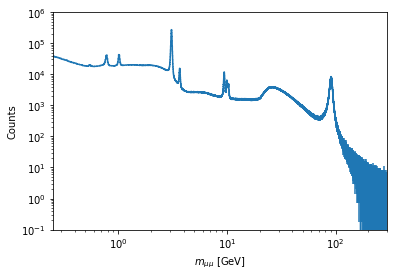

In [4]:
fig, ax, _ = plot.plot1d(masshist)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, 1e6)

In [5]:
print("Events/s:", masshist.values()[()].sum()/elapsed)

Events/s: 394261.27398674167
